In [204]:
import urllib.request
import numpy as np
import pandas as pd

In [205]:
link="https://raw.githubusercontent.com/yashgokhale/Data-Analysis-ML-of-Cloud-Data/master/CDC_0607.csv"
with urllib.request.urlopen(link) as url:
    s = url.read()
df = pd.read_csv(link, index_col=0)
df=df.drop(columns=['Unnamed: 0.1'])

In [206]:
import pyspark
from pyspark.sql import SparkSession

In [207]:
spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()

In [208]:
df.columns

Index(['Date', 'Height', 'LWC', 'LWC_SD', 'Velocity', 'Velocity_SD',
       'Spectral_Width', 'Spectral_Width_SD', 'Reflectivity',
       'Reflectivity_SD', 'Temperature', 'Extinction_low', 'Extinction',
       'Extinction_high', 'CCN', 'CDC_pinsky,k=0.3', 'Smax,k=0.3',
       'CDC_pinsky,k=0.4', 'Smax,k=0.4', 'CDC_pinsky,k=0.5', 'Smax,k=0.5',
       'CDC_pinsky,k=0.6', 'Smax,k=0.6', 'CDC_pinsky,k=0.7', 'Smax,k=0.7',
       'CDC_pinsky,k=0.8', 'Smax,k=0.8', 'CDC_pinsky,k=0.9', 'Smax,k=0.9',
       'CDC_pinsky,k=1.0', 'Smax,k=1.0', 'CDC_Fan', 'CDC_Lidar_gamma_0',
       'CDC_Lidar_gamma_1', 'CDC_Lidar_gamma_2', 'CDC_Lidar_gamma_3',
       'CDC_Lidar_gamma_4', 'CDC_Lidar_gamma_5', 'CDC_Lidar_gamma_6',
       'CDC_Lidar_gamma_7', 'CDC_Lidar_exp_0.35'],
      dtype='object')

In [209]:
ref=10**((df['Reflectivity']-180)/10)
temp=df['Temperature']
ext=df['Extinction']
w=df['Velocity_SD']
ccn=df['CCN']
lwc=df['LWC']
cdc=df['CDC_pinsky,k=0.4']
d=np.column_stack([lwc,w,temp,ccn,ext,ref,cdc])
d= np.array(d[~np.isnan(d).any(axis=1)])
d=d[np.isfinite(d).all(1)]
d_train=d[0:int(len(d)*0.7)]
d_test=d[int(len(d)*0.7):]
X=d[:,:-1]
y=d[:,-1]
names=['LWC','Velocity','Temperature','CCN','Extinction','Reflectivity','CDC']

In [210]:
train_data=spark.createDataFrame(pd.DataFrame(d_train,columns=names))
test_data=spark.createDataFrame(pd.DataFrame(d_test,columns=names))

In [211]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols=['LWC','Velocity','Temperature','CCN','Extinction','Reflectivity'],
                                  outputCol="features")

## Linear Regression Model

In [212]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='CDC', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [213]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, lr])

In [214]:
model = pipeline.fit(train_data)

In [215]:
prediction = model.transform(test_data)

In [216]:
output=prediction.select("*").toPandas()
pred=output['prediction']
real=output['CDC']

In [217]:
from sklearn.metrics import r2_score
r2_score(real,pred)

0.9561889102508673

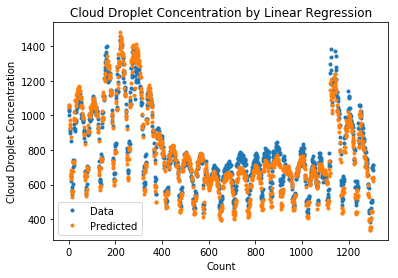

In [218]:
import matplotlib.pyplot as plt
plt.plot(real,'.',label='Data')
plt.plot(pred,'.',label='Predicted')
plt.xlabel('Count')
plt.ylabel('Cloud Droplet Concentration')
plt.title('Cloud Droplet Concentration by Linear Regression')
plt.legend()
plt.show()

## Decison Tree Regressor 

In [219]:
ref=10**((df['Reflectivity']-180)/10)
temp=df['Temperature']
ext=df['Extinction']
w=df['Velocity_SD']
ccn=df['CCN']
lwc=df['LWC']
cdc=df['CDC_pinsky,k=0.4']
d=np.column_stack([lwc,w,temp,ccn,ext,ref,cdc])
d= np.array(d[~np.isnan(d).any(axis=1)])
d=d[np.isfinite(d).all(1)]
d_train=d[0:int(len(d)*0.7)]
d_test=d[int(len(d)*0.7):]
X=d[:,:-1]
y=d[:,-1]
names=['LWC','Velocity','Temperature','CCN','Extinction','Reflectivity','CDC']
train_data=spark.createDataFrame(pd.DataFrame(d_train,columns=names))
test_data=spark.createDataFrame(pd.DataFrame(d_test,columns=names))

In [228]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
vectorAssembler = VectorAssembler(inputCols=['LWC','Velocity','Temperature','CCN','Extinction','Reflectivity'],
                                  outputCol="features")
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures")
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")
pipeline = Pipeline(stages=[VectorAssembler,VectorIndexer,dt])